In [1]:
import geopandas as gpd
import logging
import numpy as np
import os
import os.path as osp
import pandas as pd
import warnings
from shapely.geometry import box
from shapely import wkt
from pyproj import Geod
import psycopg2
from matplotlib import pyplot as plt
import sys 
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from utils.geometric_utils import read_vector_data, save_geodataframe , create_logger
from utils.haversine_distance import get_distance

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
us_geodata = read_vector_data('us-state-boundaries.geojson')
us_geodata.head(4)

,gid,arealand,division,intptlat,name,objectid,areawater,intptlon,oid,funcstat,...,state,statens,centlat,basename,mtfcc,region,lsadc,geoid,geo_point_2d,geometry
0,16,278176477,0,18.217648,Puerto Rico,50,628200285,-66.410799,303146031,A,...,72,01779808,18.216472,Puerto Rico,G4000,9,00,72,"{'lon': -66.4146425123, 'lat': 18.2157325628}","MULTIPOLYGON (((-67.20794 18.44228, -67.21713 ..."
1,23,472276664,0,14.936784,Commonwealth of the Northern Mariana Islands,36,349301029,145.601021,-1625647860,A,...,69,01779809,16.797438,Commonwealth of the Northern Mariana Islands,G4000,9,00,69,"{'lon': 145.595809651, 'lat': 16.8164771029}","MULTIPOLYGON (((145.57260 15.12502, 145.64831 ..."
2,31,1627312771,7,34.895526,Arkansas,44,-1334552525,-92.444626,266078934,A,...,05,00068085,34.894021,Arkansas,G4000,3,00,05,"{'lon': -92.4393557454, 'lat': 34.899695632}","POLYGON ((-94.55218 36.10224, -94.58620 36.299..."
3,35,2136109036,5,38.647285,West Virginia,1,489848791,-80.618327,-1929409300,A,...,54,01779805,38.641186,West Virginia,G4000,3,00,54,"{'lon': -80.6137013299, 'lat': 38.6425782646}","POLYGON ((-81.74725 39.09538, -81.74385 39.102..."


## California

In [3]:
import pandas as pd
import numpy as np
from glob import glob 
import os 
from shapely import wkt
from urllib.parse import quote 
from sqlalchemy import create_engine

<AxesSubplot:>

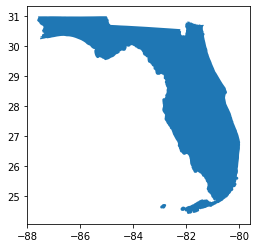

In [4]:
county_polygon = us_geodata['geometry'].loc[us_geodata.name=='Florida']

polygon_str = county_polygon.apply(lambda x: wkt.dumps(x)).iloc[0]

county_polygon.plot()
# ountry_polygon.to_string()


In [5]:
class ExtractMSFTData:
    def __init__(self, database_name='mnr',databse_server='caprod-cpp-pgmnr-002.flatns.net'):
        self.__logger__ = create_logger()
        self.host = databse_server
        self.database_name = database_name
        self.connection = self.connect_to_server()
        if self.connection:
            print("connection successfull..")
        
    def connect_to_server(self,username='cerebroadmin',password='admin@123'):
        """
        Connect to MNR Database
        :return: connection object
        """
        connection = None
        db_connection_url = "postgresql://cerebroadmin:%s@10.128.154.4:5432/postgres" % quote(password)
        alchemyengine = create_engine(db_connection_url)
        try:
            connection = alchemyengine.connect()
        except (Exception, psycopg2.DatabaseError) as error:
            self.__logger__.error("{}".format(error))
        return connection
    
    def extract_bfp(self,polygon,save=True,filename='country.shp'):
        sql_query = "SELECT st_transform(geometry, 4326) AS geom FROM dev_ppa.msft_building_footprints WHERE ST_Within(geometry,st_transform(ST_GeomFromText('{}',4326),3857))".format(polygon)
        # print(sql_query)
        gdf = gpd.GeoDataFrame.from_postgis(sql_query, self.connection)
        gdf = gdf.to_crs("epsg:4326")
        if save:
            if filename.endswith('.shp'):
                gdf.to_file(filename, driver='ESRI Shapefile')
        return gdf


test = ExtractMSFTData()
filepath = '/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data/Florida'
test.extract_bfp(polygon=polygon_str,save=True,filename=os.path.join(filepath,'Florida.shp'))

connection successfull..


,geom
0,"POLYGON ((-87.32433 30.41668, -87.32423 30.416..."
1,"POLYGON ((-87.32208 30.41864, -87.32218 30.418..."
2,"POLYGON ((-87.32250 30.42028, -87.32250 30.420..."
3,"POLYGON ((-87.32348 30.41588, -87.32347 30.415..."
4,"POLYGON ((-87.32444 30.41423, -87.32456 30.414..."
...,...
7363428,"POLYGON ((-82.30605 27.78826, -82.30619 27.788..."
7363429,"POLYGON ((-82.30637 27.79122, -82.30618 27.791..."
7363430,"POLYGON ((-82.30562 27.78858, -82.30567 27.788..."
7363431,"POLYGON ((-82.30633 27.78983, -82.30633 27.789..."


## Get All the Pkl files

In [4]:
data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data"
country = "California"
# read pkl data
pkl_path = os.path.join(data_path,country,'Apt_realignment_MSFT/')
pkl_files = glob(pkl_path+'*/*.pkl')
print("Number of pkl files found ",len(pkl_files))

Number of pkl files found  114


In [5]:
def read_data(fname):
    df_bfp = pd.read_pickle(fname)
    df_bfp.reset_index(drop=True)
    return df_bfp

out = pd.concat([read_data(fname) for fname in pkl_files])
out.head()

,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,PRCLDMPID,updated_geometries,apt_bfp_dist
26,00005543-3300-2800-0000-000000518c92,Latn,ENG,94705-1527,32,CA,Berkeley,Gravatt Dr,USA,None,Dr,None,None,Gravatt,100660192_173171558,POINT (-122.23809 37.85935),7.8
27,00005543-3300-2800-0000-000000518c93,Latn,ENG,94705-1527,22,CA,Berkeley,Gravatt Dr,USA,None,Dr,None,None,Gravatt,100660192_173171557,POINT (-122.23821 37.85946),6.9
29,00005543-3300-2800-0000-000000518c79,Latn,ENG,94705-1554,780,CA,Berkeley,Alvarado Rd,USA,None,Rd,None,None,Alvarado,100660192_173171555,POINT (-122.23866 37.85943),3.1
30,00005543-3300-2800-0000-000000518c7c,Latn,ENG,94705-1554,770,CA,Berkeley,Alvarado Rd,USA,None,Rd,None,None,Alvarado,100660192_173171554,POINT (-122.23873 37.85957),2.7
31,00005543-3300-2800-0000-000000518c7b,Latn,ENG,94705-1555,733,CA,Berkeley,Alvarado Rd,USA,None,Rd,None,None,Alvarado,100660192_173171553,POINT (-122.23928 37.85965),7.8


In [ ]:
out.to_pickle(os.path.join(pkl_path,'Final_Updated_geom_{}.pkl'.format(country)))

## Post data to DB

In [ ]:
passowrd = 'admin@123'
db_connection_url = "postgresql://cerebroadmin:%s@10.128.154.4:5432/postgres" % quote(passowrd)
con = create_engine(db_connection_url)

In [ ]:
output_pkl = os.path.join(pkl_path,'Final_Updated_geom_{}.pkl'.format(country))
updated_pkl = pd.read_pickle(output_pkl)

gdf = gpd.GeoDataFrame(updated_pkl, crs=4326,geometry='updated_geometries')
gdf.head()

In [ ]:
gdf.to_postgis(name="updated_APT_Texas", schema='dev_apa', con=con, index=False, if_exists='append')